In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow import keras

from keras.datasets import cifar10
import string
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Fri May  6 01:14:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Acquiring Dataset

In [ ]:
# import sys
# prefix = '/content/gdrive/SharedDrives/'
# # modify "customized_path_to_your_homework" here to where you uploaded your homework
# customized_path_to_your_homework = 'AML_Project/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/'
# sys_path = prefix + customized_path_to_your_homework
# sys.path.append(sys_path)

In [ ]:
# path_files = prefix + "AML_Project/"
# sys.path.append(path_files)

In [ ]:
# loaded_ytr = np.loadtxt('/content/gdrive/Shareddrives/AML_Project/y_train_final.txt')
# trainy = loaded_ytr.reshape(loaded_ytr.shape[0], 43)

In [ ]:
# loaded_xtr = np.loadtxt('/content/gdrive/Shareddrives/AML_Project/X_train_final.txt')
# trainX = loaded_xtr.reshape(loaded_xtr.shape[0], 32,32,3)

In [ ]:
# loaded_yte = np.loadtxt('/content/gdrive/Shareddrives/AML_Project/y_test_final.txt')
# testy = loaded_yte.reshape(loaded_yte.shape[0], 43)

In [ ]:
# loaded_xte = np.loadtxt('/content/gdrive/Shareddrives/AML_Project/X_test_final.txt')
# testX = loaded_xte.reshape(loaded_xte.shape[0], 32,32,3)

In [ ]:
# X_train = trainX
# y_train = trainy
# X_test = testX
# y_test = testy

In [ ]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

(39209, 32, 32, 3)
(39209, 43)
(12630, 32, 32, 3)
(12630, 43)


## Kaggle

In [ ]:
%%capture
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets list -s ['gtsrb']

ref                                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          54781        807  0.8235294        
datasets/eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            269          7  0.75             
datasets/shanmukh05/traffic-sign-cropped                                    Traffic Sign Recognition Cropped Images             43MB  2021-03-05 11:49:40            460         18  0.88235295       
datas

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 602M/612M [00:04<00:00, 149MB/s]
100% 612M/612M [00:04<00:00, 141MB/s]


In [ ]:
%%capture
!unzip gtsrb-german-traffic-sign.zip

In [ ]:
# Labels Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
data_dir = '/content/'
train_path = '/content/Train'
test_path = '/content/Test'

In [ ]:
n = pd.read_csv(data_dir + '/Train.csv')
n_classes = len(set(n['ClassId'].values))
print(f"Number of classes: {n_classes}")

Number of classes: 43


## Visualizing Dataset

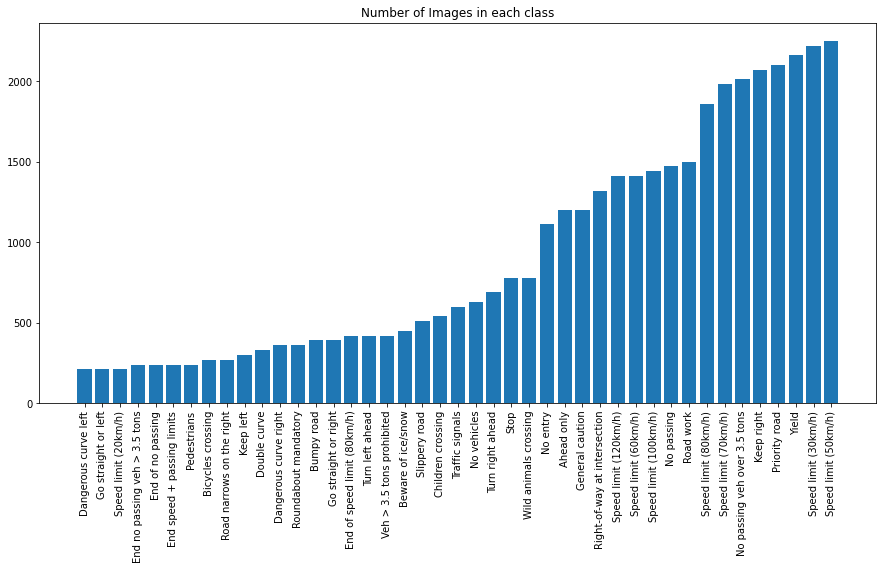

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(15,7))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.title("Number of Images in each class")
plt.show()

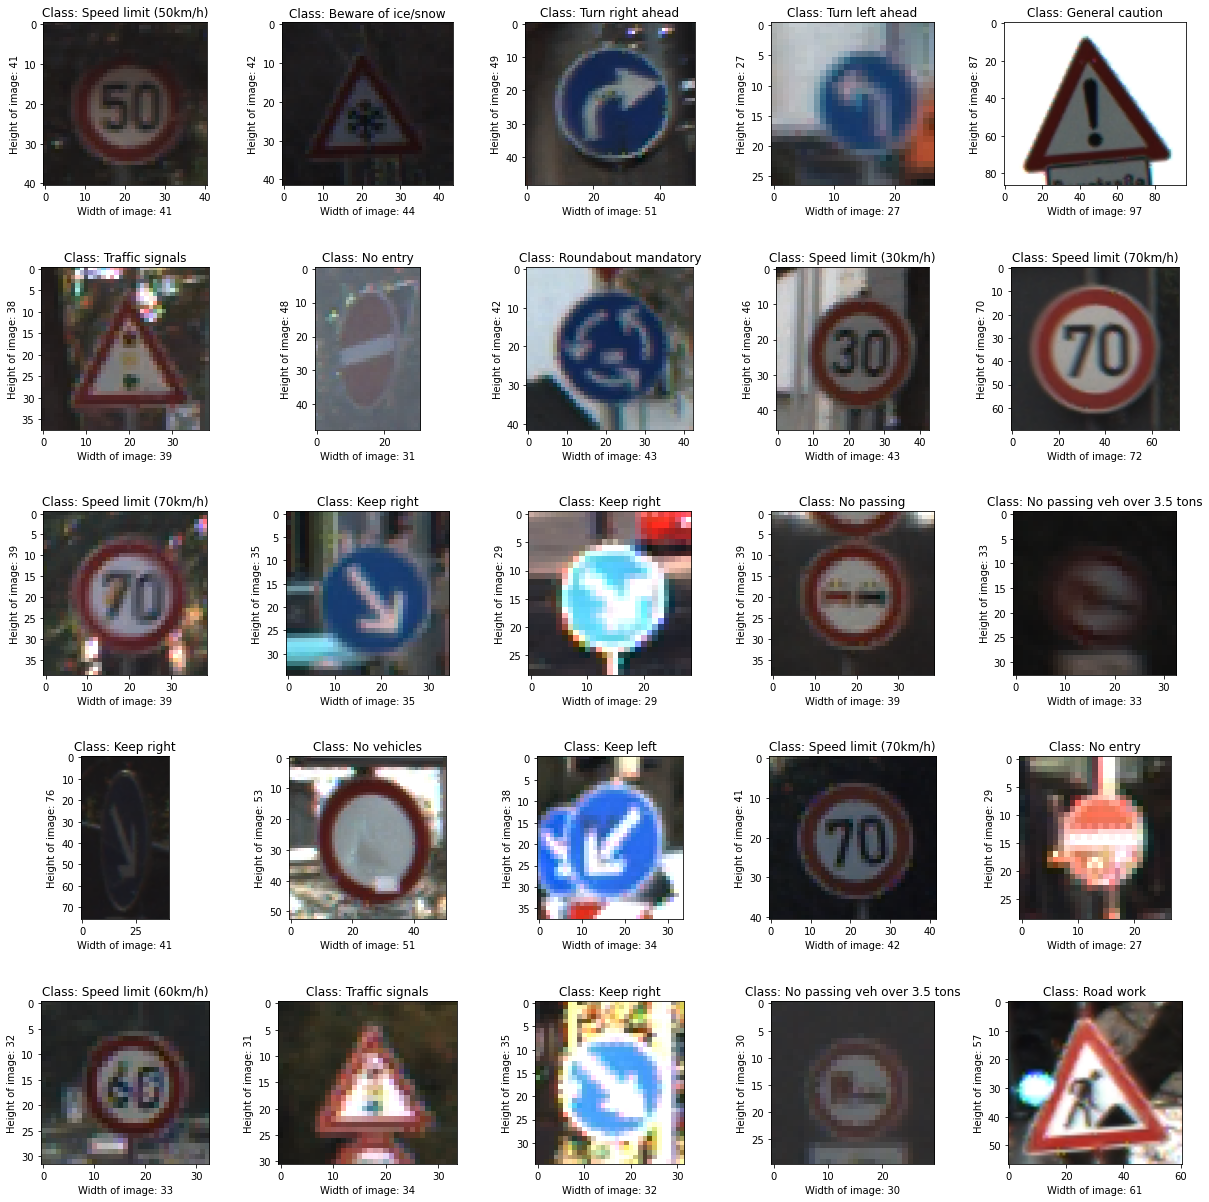

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values
ids = test["ClassId"].values
mat = np.column_stack((ids,imgs))

plt.figure(figsize=(21,21))
plt.subplots_adjust(hspace=.5)

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path_id = random.choice(mat)
    rand_img = imread(data_dir + '/' + random_img_path_id[1])
    rand_id = random_img_path_id[0]
    plt.imshow(rand_img)
    plt.xlabel(f"Width of image: {rand_img.shape[1]}")     #width of image
    plt.ylabel(f"Height of image: {rand_img.shape[0]}")    #height of image
    plt.title(f"Class: {classes.get(rand_id)}")

## Creating Dataset

In [ ]:
data = []
labels = []

for i in range(n_classes):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
      image = cv2.imread(path + '/' + img)
      rz = cv2.resize(image, (32,32), interpolation = cv2.INTER_NEAREST)
      data.append(np.array(rz))
      labels.append(i)

data = np.array(data)
labels = np.array(labels)
print(f"data shape: {data.shape}")
print(f"labels shape: {labels.shape}")

data shape: (39209, 32, 32, 3)
labels shape: (39209,)


(32, 32, 3)


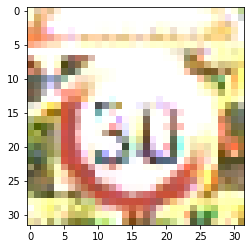

1


In [ ]:
print(data[300].shape)
img = cv2.cvtColor(data[300], cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(labels[300])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=41, shuffle=True)

X_train = X_train/255     # Normalizing Values
X_val = X_val/255         # Normalizing Values
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

y_train.shape (31367, 43)
y_valid.shape (7842, 43)


In [ ]:
def AlexNet(X):
  AlexNet = Sequential()

  # 1st Convolution Layer
  AlexNet.add(Conv2D(filters=96, input_shape=(X.shape[1],X.shape[2],X.shape[3]), kernel_size=(5,5), activation='relu', strides=(1,1), padding='valid'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 2nd Convolution Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # 3rd Convolution Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))

  # 4th Convolution Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))

  # 5th Convolution Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

  # Fully Connected Layers
  AlexNet.add(Flatten())
  AlexNet.add(Dense(400, activation='relu'))
  AlexNet.add(Dropout(0.2))
  AlexNet.add(Dense(160, activation='relu'))
  AlexNet.add(Dropout(0.2))
  AlexNet.add(Dense(43, activation='softmax'))

  return AlexNet

model_alex = AlexNet(X_train)
model_alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        7296      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

## Visualizing Model


In [ ]:
!pip install visualkeras

     |████████████████████████████████| 992 kB 115 kB/s 


In [ ]:
import visualkeras
from PIL import ImageFont

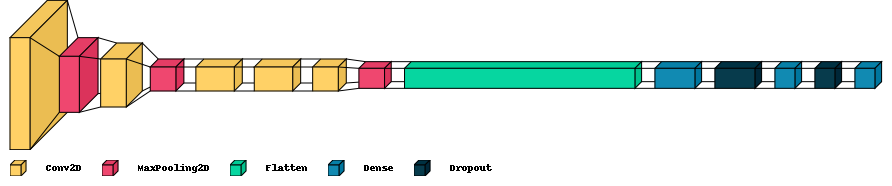

In [ ]:
visualkeras.layered_view(model_alex, legend=True, spacing = 20) 

## Training

In [ ]:
# Parameters
bs = 32
ep = 50
lr = 0.001

opt = Adam(learning_rate=lr, decay=lr / (ep * 0.5))
model_alex.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Augmenting Training Data
data_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history_alex = model_alex.fit(data_gen.flow(X_train, y_train, batch_size=bs), epochs=ep, validation_data=(X_val, y_val))

Epoch 1/50
981/981 [==============================] - 22s 20ms/step - loss: 2.6090 - accuracy: 0.2338 - val_loss: 1.4331 - val_accuracy: 0.4944
Epoch 2/50
981/981 [==============================] - 20s 20ms/step - loss: 1.0924 - accuracy: 0.6284 - val_loss: 0.4227 - val_accuracy: 0.8585
Epoch 3/50
981/981 [==============================] - 20s 21ms/step - loss: 0.4538 - accuracy: 0.8513 - val_loss: 0.1792 - val_accuracy: 0.9455
Epoch 4/50
981/981 [==============================] - 19s 20ms/step - loss: 0.2567 - accuracy: 0.9176 - val_loss: 0.1043 - val_accuracy: 0.9674
Epoch 5/50
981/981 [==============================] - 20s 20ms/step - loss: 0.1818 - accuracy: 0.9431 - val_loss: 0.0805 - val_accuracy: 0.9749
Epoch 6/50
981/981 [==============================] - 20s 20ms/step - loss: 0.1481 - accuracy: 0.9551 - val_loss: 0.0539 - val_accuracy: 0.9842
Epoch 7/50
981/981 [==============================] - 19s 20ms/step - loss: 0.1256 - accuracy: 0.9624 - val_loss: 0.0768 - val_accuracy:

In [ ]:
model_alex.save('/content/gdrive/Shareddrives/AML_Project/alex.h5')

In [ ]:
model_alex.save('/content/gdrive/Shareddrives/AML_Project/alex_final')

INFO:tensorflow:Assets written to: /content/gdrive/Shareddrives/AML_Project/alex_final/assets


In [ ]:
reconstructed_model = keras.models.load_model("/content/gdrive/Shareddrives/AML_Project/alex_final")

## Evaluating Model

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history_alex.history['accuracy'])
plt.plot(history_alex.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

<Figure size 1080x504 with 0 Axes>

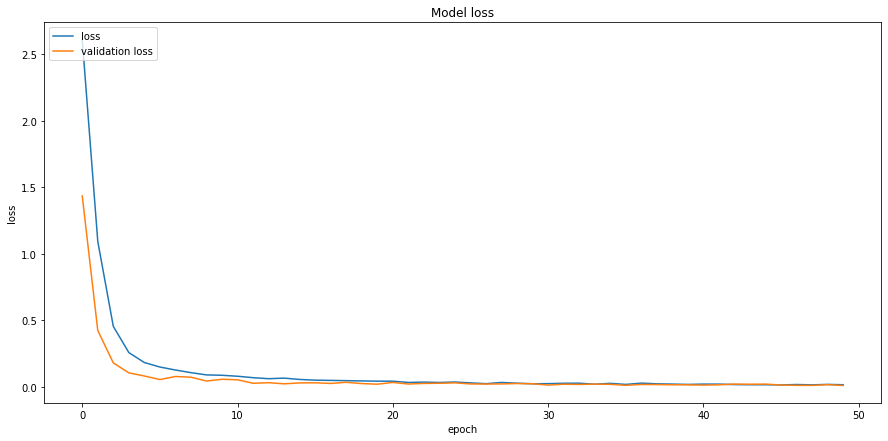

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history_alex.history['loss'])
plt.plot(history_alex.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'validation loss'], loc='upper left')
plt.show()

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

test_labels = test["ClassId"].values
test_imgs = test["Path"].values
print(len(test_imgs))
test_data =[]

for img in test_imgs:
  image = cv2.imread(data_dir+'/'+img)
  rz = cv2.resize(image, (32, 32), interpolation = cv2.INTER_NEAREST)
  test_data.append(rz)

X_test = np.array(test_data)
X_test = X_test/255         # Normalizing Values

print("X_test.shape", X_test.shape)

12630
X_test.shape (12630, 32, 32, 3)


In [ ]:
from sklearn.metrics import accuracy_score
pred = reconstructed_model.predict(X_test)
pred_classes=np.argmax(pred, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_labels, pred_classes)*100)

Test Data accuracy:  96.84085510688836


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.97      0.98      0.97       720
           2       0.92      0.98      0.95       750
           3       0.97      0.97      0.97       450
           4       0.99      0.97      0.98       660
           5       0.96      0.95      0.95       630
           6       0.98      0.90      0.94       150
           7       0.99      0.94      0.97       450
           8       0.95      0.98      0.97       450
           9       1.00      0.99      0.99       480
          10       1.00      1.00      1.00       660
          11       0.95      0.98      0.96       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.93      1.00      0.96       270
          15       0.99      0.97      0.98       210
          16       0.98      1.00      0.99       150
          17       1.00    

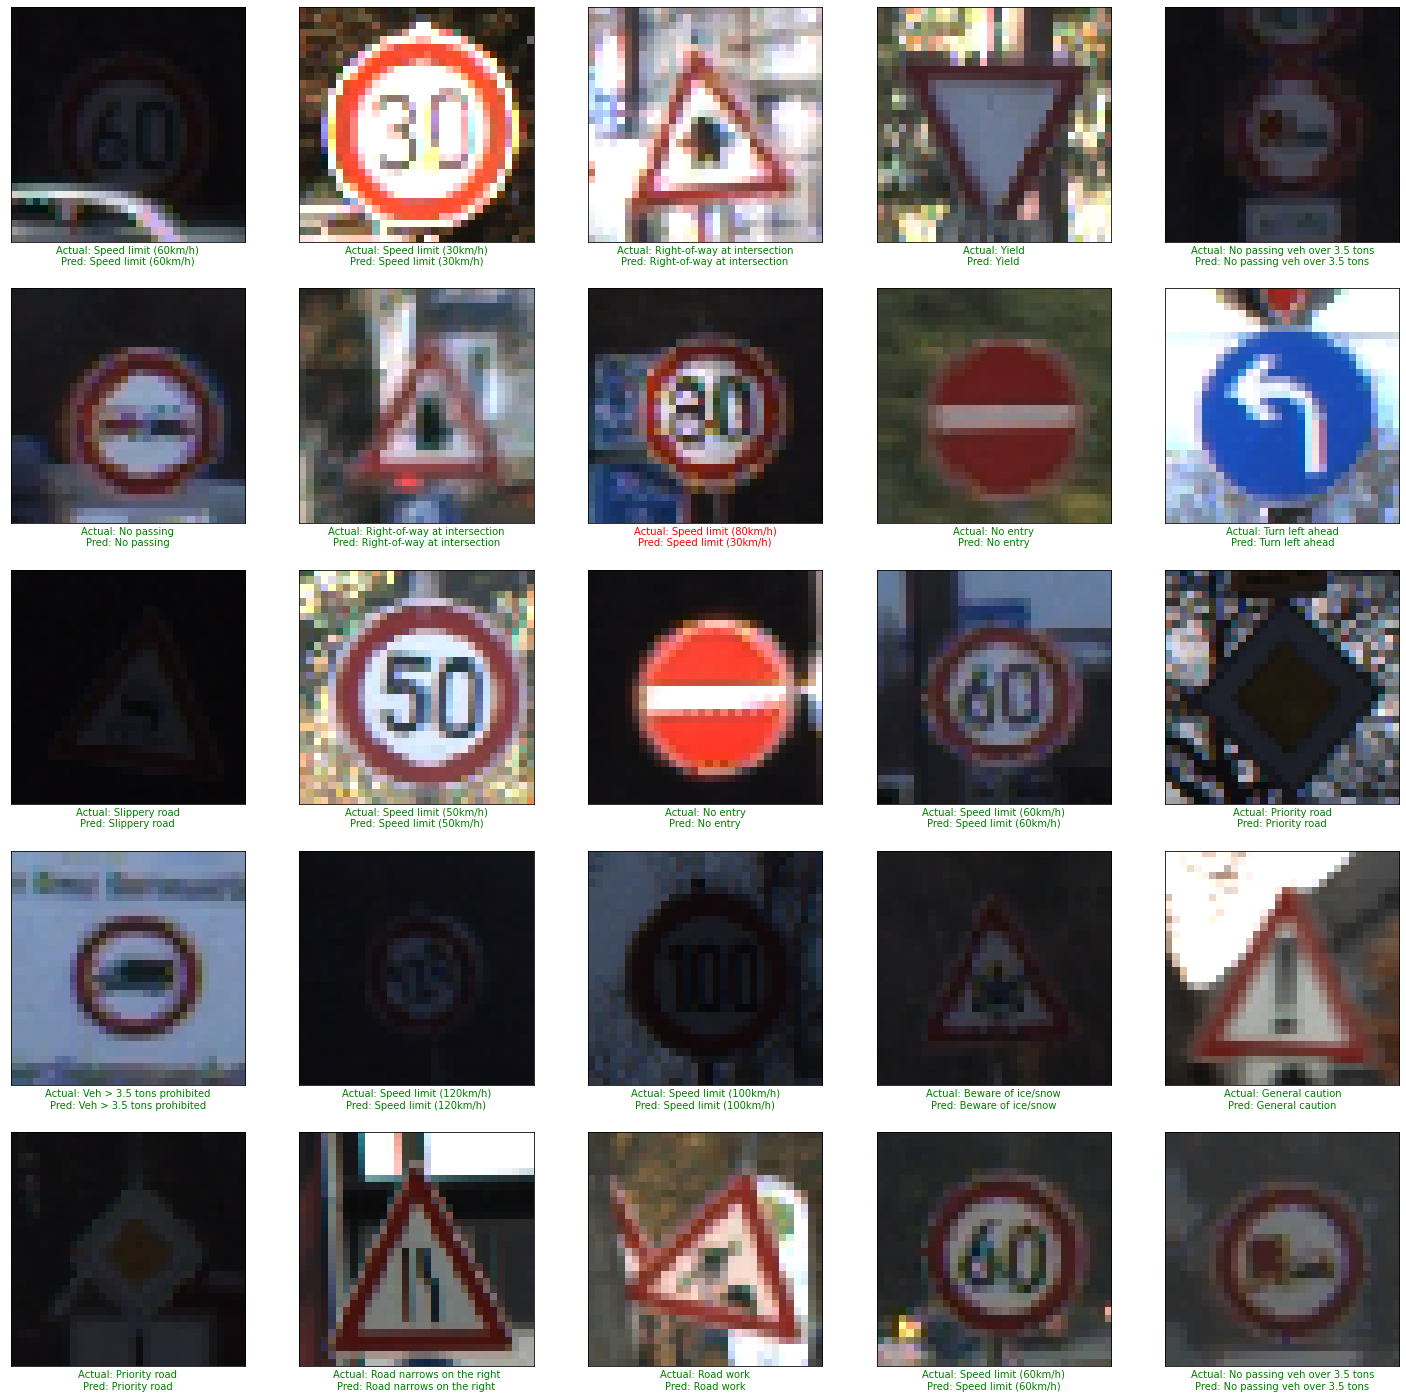

In [ ]:
plt.figure(figsize = (25, 25))

start_idx = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_idx + i + 23]
    actual = test_labels[start_idx + i + 23]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.imshow(cv2.cvtColor(np.array(X_test[start_idx + i + 23], dtype=np.float32), cv2.COLOR_BGR2RGB))
    plt.xlabel(f'Actual: {classes.get(actual)}''\n'f'Pred: {classes.get(prediction)}', color = col)
plt.show()